<a href="https://colab.research.google.com/github/A-Wadhwani/ME597-Project/blob/main/Purdue_Power_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Models on Purdue Buildings

In [6]:
# import the libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import datetime
import seaborn as sns 
import tensorflow as tf
import math
import pandas as pd
from datetime import datetime
from sklearn.metrics import r2_score
print("TensorFlow version: ",tf.__version__)  #print the version of tensorflow

TensorFlow version:  2.3.0


In [7]:
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [8]:
#Helper Functions
def get_weekday2(year, month, day):
    dates = pd.DataFrame()
    dates['y'] = year
    dates['m'] = month
    dates['d'] = day
    dates['dates'] = dates['y'].astype('str') + '-' + dates['m'].astype('str') + '-' + dates['d'].astype('str')
    return get_weekday(dates['dates'])

#Get day of week based on date
def get_weekday(dates):
    return [1 if (datetime.strptime(d,"%Y-%m-%d").weekday() >= 5) else 0 for d in dates]

In [9]:
from joblib import dump, load

#Load university model scalers
uni_x_scaler = load('uni_x_scaler.bin')
uni_y_scaler = load('uni_y_scaler.bin')

#Load solar model scalers
sol_x_scaler = load('sol_x_scaler.bin')
sol_y_scaler = load('sol_y_scaler.bin')

In [10]:
#Load university model
uni_model= tf.keras.models.load_model('uni_model.h5')

#Load solar model
sol_model= tf.keras.models.load_model('sol_model.h5')

In [11]:
#Load Purdue weather data
df_weather = pd.read_csv('https://raw.githubusercontent.com/A-Wadhwani/ME597-Project/main/Datasets/Purdue_Weather.csv')
df_weather.head()

,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure
0,2019,1,1,0,30,0,0,0,0,0,0,8.7,1.5,245,100.00,7.2,981
1,2019,1,1,1,30,0,0,0,0,0,0,8.2,1.4,254,99.64,5.4,982
2,2019,1,1,2,30,0,0,0,0,0,0,7.3,1.3,265,99.24,3.8,984
3,2019,1,1,3,30,0,0,0,0,0,0,6.2,1.2,276,98.59,2.5,987
4,2019,1,1,4,30,0,0,0,0,0,0,5.2,1.2,280,97.39,1.6,989


## Power Consumption prediction

In [12]:
def uni_clean_data(df, skiprows = 0):
    df_weather = df
    df_weather = df_weather.drop(columns=['Hour', 'Minute'])
    df_weather = df_weather[df_weather.DNI != 0]

    #Take mean, max and min for each DNI in DataFrame and mean for everything else
    
    #Take mean, max and min for each DNI and Temperature in DataFrame and mean for everything else
    max_temp = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['Temperature']
    min_temp = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['Temperature']
    
    max_dni = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['DNI']
    min_dni = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['DNI']
    
    df_weather = pd.DataFrame(df_weather.groupby(['Year', 'Month', 'Day']).mean().reset_index())
    
    df_weather.insert(4, 'DNI Max', max_dni)
    df_weather.insert(5, 'DNI Min', min_dni)
    df_weather.insert(11, 'Temp Max', max_temp)
    df_weather.insert(12, 'Temp Min', min_temp)

    return df_weather

In [13]:
def uni_training_prep(data, square_feet, building_type):
    data = data.loc[:, ['Year', 'Month', 'Day', 'DNI', 'DNI Max', 'DNI Min', 'Wind Speed', 'Precipitable Water', 'Wind Direction', 'Relative Humidity', 'Temperature', 'Temp Max', 'Temp Min', 'Pressure']]
    data.loc[:, 'Weekday'] = get_weekday2(data['Year'], data['Month'], data['Day'])
    data = data.drop(['Wind Direction'], axis=1)
    data.loc[:, 'Square Feet'] = square_feet
    data.loc[:, 'Type'] = building_type
    return data

In [14]:
#Taking Lawson Building: 10700 square feet and classroom (0)
uni_df = uni_training_prep(uni_clean_data(df_weather), 10700, 0)
uni_df.head()

,Year,Month,Day,DNI,DNI Max,DNI Min,Wind Speed,Precipitable Water,Relative Humidity,Temperature,Temp Max,Temp Min,Pressure,Weekday,Square Feet,Type
0,2019,1,1,8.0,8,8,2.500,0.900,88.7200,-0.500,-0.5,-0.5,1001.00,0,10700,0
1,2019,1,2,9.5,20,4,3.775,0.975,78.8375,1.325,2.1,-0.1,999.25,0,10700,0
2,2019,1,3,702.1,934,83,3.760,0.600,68.0630,1.170,3.9,-3.0,995.40,0,10700,0
3,2019,1,4,423.4,823,106,1.000,0.860,70.5130,3.740,6.3,-0.4,986.20,0,10700,0
4,2019,1,5,632.7,902,101,3.320,1.100,82.5930,5.850,10.1,-0.3,990.50,1,10700,0


In [15]:
#Running model on data
x_scaled = uni_x_scaler.transform(uni_df)
y_scaled = uni_model.predict(x_scaled)
y_result = uni_y_scaler.inverse_transform(y_scaled)
pd.DataFrame(y_result).describe()

,0
count,364.000000
mean,830.789307
std,107.085785
min,633.323608
25%,765.372925
50%,814.082642
75%,882.192444
max,1404.280884


In [16]:
#Storing power production value in new variableb 
uni_power_lawson =  y_result

## Solar Power Prediction data

In [17]:
def sol_clean_data(df, skiprows = 0):
    df_weather = df
    df_weather = df_weather.drop(columns=['Hour', 'Minute'])
    df_weather = df_weather[df_weather.DNI != 0]

    #Take mean, max and min for each DNI in DataFrame and mean for everything else
    
    #Take mean, max and min for each DNI and Temperature in DataFrame and mean for everything else
    max_temp = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['Temperature']
    min_temp = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['Temperature']
    
    max_dni = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['DNI']
    min_dni = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['DNI']
    
    df_weather = pd.DataFrame(df_weather.groupby(['Year', 'Month', 'Day']).mean().reset_index())
    
    df_weather.insert(4, 'DNI Max', max_dni)
    df_weather.insert(5, 'DNI Min', min_dni)
    df_weather.insert(11, 'Temp Max', max_temp)
    df_weather.insert(12, 'Temp Min', min_temp)

    return df_weather

In [18]:
def sol_training_prep(data):
    data = data.loc[:, ['DHI','DNI Max', 'DNI Min', 'DNI', 'GHI', 'Clearsky DNI', 'Clearsky DHI', 'Clearsky GHI', 'Wind Speed', 'Precipitable Water', 'Relative Humidity', 'Temperature','Temp Max','Temp Min' ,'Pressure']]
    return data

In [19]:
#Taking Lawson Building: 10700 square feet and classroom (0)
sol_df = sol_training_prep(sol_clean_data(df_weather))
sol_df.head()

,DHI,DNI Max,DNI Min,DNI,GHI,Clearsky DNI,Clearsky DHI,Clearsky GHI,Wind Speed,Precipitable Water,Relative Humidity,Temperature,Temp Max,Temp Min,Pressure
0,8.00,8,8,8.0,8.00,125.00,22.0,28.00,2.500,0.900,88.7200,-0.500,-0.5,-0.5,1001.00
1,75.25,20,4,9.5,77.75,586.25,72.5,289.75,3.775,0.975,78.8375,1.325,2.1,-0.1,999.25
2,43.30,934,83,702.1,273.10,702.10,43.3,273.10,3.760,0.600,68.0630,1.170,3.9,-3.0,995.40
3,73.60,823,106,423.4,211.10,689.00,44.6,270.70,1.000,0.860,70.5130,3.740,6.3,-0.4,986.20
4,46.60,902,101,632.7,264.30,676.50,44.9,268.80,3.320,1.100,82.5930,5.850,10.1,-0.3,990.50


In [20]:
#Running model on data
x_scaled = sol_x_scaler.transform(sol_df)
y_scaled = sol_model.predict(x_scaled)
y_result = sol_y_scaler.inverse_transform(y_scaled)
pd.DataFrame(y_result).describe()

,0
count,364.000000
mean,1.503357
std,0.470166
min,0.369194
25%,1.205906
50%,1.675509
75%,1.837819
max,2.289015


In [21]:
#Storing Solar Production for Lawson value in new variable 
sol_power_lawson =  y_result

## Calculating necessary solar panels needed for Lawson Building

In [22]:
num_panels = uni_power_lawson / (sol_power_lawson)

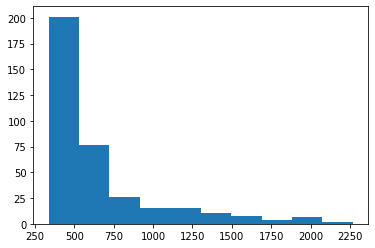

In [23]:
plt.hist(num_panels)
plt.show()

In [24]:
pd.DataFrame(num_panels).describe(percentiles=[0.25, 0.75, 0.9])

,0
count,364.000000
mean,658.029053
std,374.765564
min,335.507172
25%,436.720177
50%,502.199524
75%,703.211487
90%,1212.460229
max,2269.239014


In [25]:
# Taking three values: minimum, 50% and maximum
min = np.min(num_panels)
median = np.median(num_panels)
percentile_75th = np.percentile(num_panels, 75)

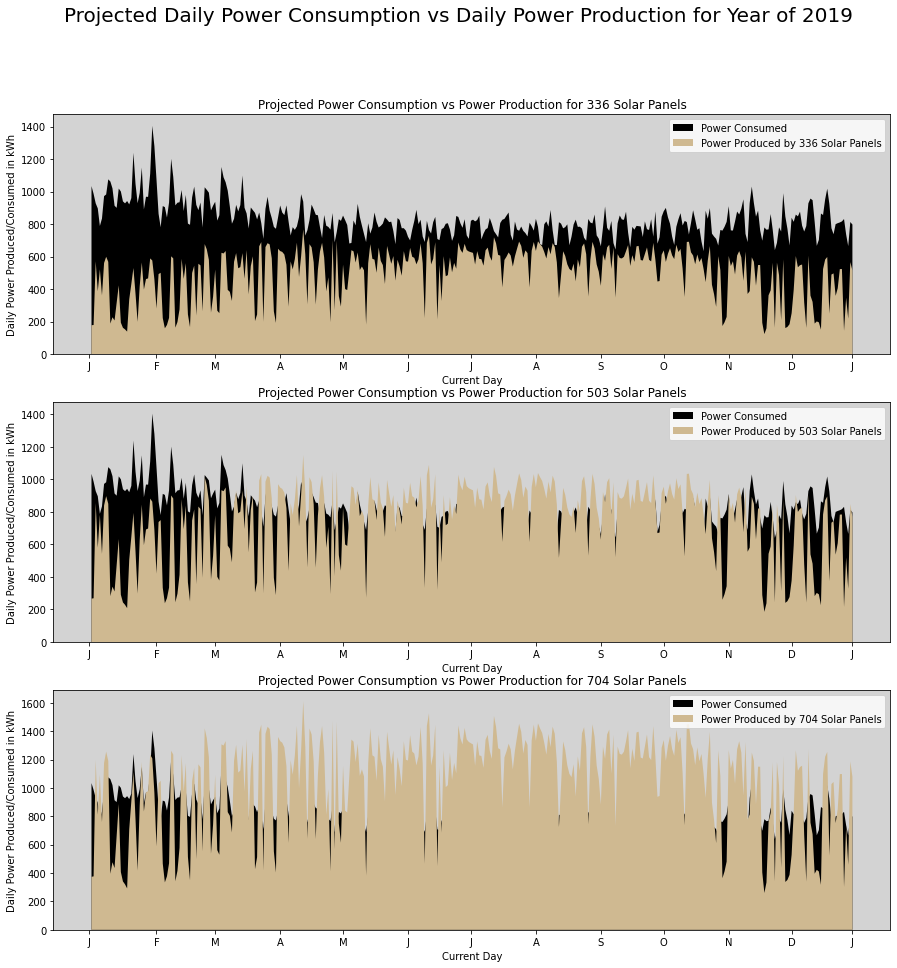

<Figure size 1440x540 with 0 Axes>

In [26]:
#Calcualte power production for all three datas
power_produced1 = sol_power_lawson * min
power_produced2 = sol_power_lawson * median
power_produced3 = sol_power_lawson * percentile_75th

#Power consumed is uni_power_lawson
power_consumed = uni_power_lawson

# Power Combined Dataframe
power_combined = pd.DataFrame()
power_combined['Range'] = list(range(1,365))
power_combined['Power Consumed'] = power_consumed.ravel()
power_combined['Power Produced 1'] = power_produced1.ravel()
power_combined['Power Produced 2'] = power_produced2.ravel()
power_combined['Power Produced 3'] = power_produced3.ravel()

fig, ax = plt.subplots(3,1)

fig.set_figheight(15)
fig.set_figwidth(15)
plt.figure(figsize=(20,7.5))

ax[0].set_title('Projected Power Consumption vs Power Production for 336 Solar Panels')
ax[0].set_facecolor('LightGrey')
ax[0].stackplot(power_combined['Range'].values, power_combined['Power Consumed'].values, colors=['Black'], labels = ['Power Consumed'])
ax[0].stackplot(power_combined['Range'].values, power_combined['Power Produced 1'].values, colors=['#CFB991'], 
                labels = ['Power Produced by ' + str(math.ceil(min)) + ' Solar Panels'])
ax[0].set_xlabel('Current Month')
ax[0].set_ylabel('Daily Power Produced/Consumed in kWh')
ax[0].set_xticks([0, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 364])
ax[0].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J'])
ax[0].legend()

ax[1].set_title('Projected Power Consumption vs Power Production for 503 Solar Panels')
ax[1].set_facecolor('LightGrey')
ax[1].stackplot(power_combined['Range'].values, power_combined['Power Consumed'].values, colors=['Black'], labels = ['Power Consumed'])
ax[1].stackplot(power_combined['Range'].values, power_combined['Power Produced 2'].values, colors=['#CFB991'], 
                labels = ['Power Produced by ' + str(math.ceil(median)) + ' Solar Panels'])
ax[1].set_xlabel('Current Month')
ax[1].set_ylabel('Daily Power Produced/Consumed in kWh')
ax[1].set_xticks([0, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 364])
ax[1].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J'])
ax[1].legend()

ax[2].set_title('Projected Power Consumption vs Power Production for 704 Solar Panels')
ax[2].set_facecolor('LightGrey')
ax[2].stackplot(power_combined['Range'].values, power_combined['Power Consumed'].values, colors=['Black'], labels = ['Power Consumed'])
ax[2].stackplot(power_combined['Range'].values, power_combined['Power Produced 3'].values, colors=['#CFB991'], 
                labels = ['Power Produced by ' + str(math.ceil(percentile_75th)) + ' Solar Panels'])
ax[2].set_xlabel('Current Month')
ax[2].set_ylabel('Daily Power Produced/Consumed in kWh')
ax[2].set_xticks([0, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 364])
ax[2].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J'])
ax[2].legend()

#Displaying daily power production in three levels vs power consumption
fig.suptitle('Projected Daily Power Consumption vs Daily Power Production for Year of 2019', fontsize=20)
fig.show()